# LightGCN with Globo Dataset and TimedLastItemPrediction Scenario

In this notebook, the implementation of LightGCN in RecPack and the experimental part to generate the results of the algorithm will be presented. 
The notebook contains:
1. The implementation of LightGCN in RecPack.
2. The 10% of Globo Dataset from RecPack and the TimedLastItemPrediction Scenario has been used to split the data.
3. The TimedLastItemPrediction Scenario to split the data.
4. The RecPack Pipeline Builder to run the experiments, including the splitted dataset, the algorithms and metrics to run. Hyperparameter has been performed in the Pipeline.

Please make sure you have installed all the latest libraries in your Python environment, in order to have a successful run of the code.

In [1]:
import torch
from tqdm import tqdm

In [3]:
from torch_sparse import SparseTensor, matmul

## LightGCN implementation in RecPack

In [4]:
import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import time
from typing import List, Tuple, Optional
from tqdm import tqdm
from recpack.algorithms.base import TorchMLAlgorithm
from recpack.matrix.interaction_matrix import InteractionMatrix
from recpack.matrix import to_csr_matrix
from recpack.algorithms.loss_functions import bpr_loss
from recpack.algorithms.samplers import PositiveNegativeSampler
from scipy.sparse import csr_matrix, lil_matrix
import torch.optim as optim
import logging

# logger = logging.getLogger(__name__)

# LightGCN model definition using MessagePassing from PyTorch Geometric
class LightGCN(MessagePassing):
    def __init__(self, num_users, num_items, embedding_dim=64, K=3, add_self_loops=False):
        """
        Initialize the LightGCN model with user and item embeddings.

        Args:
            num_users (int): Number of users.
            num_items (int): Number of items.
            embedding_dim (int): Dimension of the embedding vectors.
            K (int): Number of propagation layers.
            add_self_loops (bool): Whether to add self-loops to the adjacency matrix.
        """
        super(LightGCN, self).__init__(aggr='add')
        self.num_users, self.num_items = num_users, num_items
        self.embedding_dim, self.K = embedding_dim, K
        self.add_self_loops = add_self_loops

        # Initialize user and item embeddings
        self.users_emb = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_dim)
        self.items_emb = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_dim)

        # Initialize embeddings with normal distribution
        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

    def forward(self, edge_index: SparseTensor):
        """
        Forward pass for the LightGCN model.

        Args:
            edge_index (SparseTensor): Sparse tensor representing the adjacency matrix.

        Returns:
            Tuple: Final user and item embeddings after propagation, and the initial embeddings.
        """
        if self.add_self_loops:
            edge_index, _ = add_self_loops(edge_index, num_nodes=self.num_users + self.num_items)
        
        # Normalize the adjacency matrix
        edge_index_norm = self.normalize_adj(edge_index)
        
        # Concatenate user and item embeddings
        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight])
        embs = [emb_0]
        emb_k = emb_0

        # Perform K propagation steps
        for i in range(self.K):
            # Preventing CUDA/Library version error
            try:
                emb_k = self.propagate(edge_index_norm, x=emb_k)
            except RuntimeError as e:
                break
            embs.append(emb_k)

        # Stack and average embeddings from each propagation step
        embs = torch.stack(embs, dim=1)
        emb_final = torch.mean(embs, dim=1)

        # Split the final embeddings back into user and item embeddings
        users_emb_final, items_emb_final = torch.split(emb_final, [self.num_users, self.num_items])

        return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight

    def message(self, x_j: torch.Tensor) -> torch.Tensor:
        """
        Message function that aggregates messages from neighboring nodes.

        Args:
            x_j (torch.Tensor): Features of the neighboring nodes.

        Returns:
            torch.Tensor: Aggregated messages.
        """
        return x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: torch.Tensor) -> torch.Tensor:
        """
        Message and aggregate function using matrix multiplication.

        Args:
            adj_t (SparseTensor): Transposed adjacency matrix.
            x (torch.Tensor): Node features.

        Returns:
            torch.Tensor: Result of multiplying adjacency matrix with node features.
        """
        return matmul(adj_t, x)

    def normalize_adj(self, edge_index: SparseTensor) -> SparseTensor:
        """
        Normalize the adjacency matrix.

        Args:
            edge_index (SparseTensor): Sparse tensor representing the adjacency matrix.

        Returns:
            SparseTensor: Normalized adjacency matrix.
        """
        row, col, value = edge_index.coo()
        row = row.long()  # Ensure indices are long type
        col = col.long()  # Ensure indices are long type
        deg = degree(row, num_nodes=edge_index.size(0), dtype=value.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        value = deg_inv_sqrt[row] * value * deg_inv_sqrt[col]
        return SparseTensor(row=row, col=col, value=value, sparse_sizes=edge_index.sparse_sizes())


In [5]:
from recpack.algorithms.base import TorchMLAlgorithm
from recpack.matrix import Matrix
from recpack.matrix.interaction_matrix import InteractionMatrix
from recpack.algorithms.loss_functions import bpr_loss, bpr_max_loss
from recpack.algorithms.samplers import PositiveNegativeSampler
from recpack.algorithms.stopping_criterion import (
    EarlyStoppingException,
    StoppingCriterion,
)
from typing import List, Tuple, Optional
import numpy as np
from scipy.sparse import csr_matrix, lil_matrix, coo_matrix
import torch
import torch.optim as optim
import tempfile
import time
import logging

logger = logging.getLogger(__name__)

# Implementation of the LightGCN algorithm using TorchMLAlgorithm as a base class
class LightGCNAlgorithm(TorchMLAlgorithm):
    def __init__(
        self,
        batch_size: int = 256,
        max_epochs: int = 100,
        learning_rate: float = 0.001,
        embedding_dim: int = 64,
        n_layers: int = 3,
        reg_weight: float = 1e-5,
        stopping_criterion: str = "bpr",
        stop_early: bool = True,
        max_iter_no_change: int = 5,
        min_improvement: float = 0.01,
        seed: Optional[int] = None,
        save_best_to_file: bool = False,
        keep_last: bool = False,
        predict_topK: Optional[int] = None,
        validation_sample_size: Optional[int] = None,
    ):
        """
        Initialize the LightGCNAlgorithm with various hyperparameters.

        Args:
            batch_size (int): Number of samples per batch.
            max_epochs (int): Maximum number of training epochs.
            learning_rate (float): Learning rate for the optimizer.
            embedding_dim (int): Dimension of the embedding vectors.
            n_layers (int): Number of LightGCN layers.
            reg_weight (float): Regularization weight.
            stopping_criterion (str): Criterion to stop training early.
            stop_early (bool): Whether to enable early stopping.
            max_iter_no_change (int): Maximum iterations with no improvement for early stopping.
            min_improvement (float): Minimum improvement required for early stopping.
            seed (Optional[int]): Random seed for reproducibility.
            save_best_to_file (bool): Whether to save the best model to a file.
            keep_last (bool): Whether to keep the last model.
            predict_topK (Optional[int]): Number of top-K predictions to consider.
            validation_sample_size (Optional[int]): Size of the validation sample.
        """
        self.embedding_dim = embedding_dim
        self.n_layers = n_layers
        self.reg_weight = reg_weight
        super().__init__(
            batch_size=batch_size,
            max_epochs=max_epochs,
            learning_rate=learning_rate,
            stopping_criterion=stopping_criterion,
            stop_early=stop_early,
            max_iter_no_change=max_iter_no_change,
            min_improvement=min_improvement,
            seed=seed,
            save_best_to_file=save_best_to_file,
            keep_last=keep_last,
            predict_topK=predict_topK,
            validation_sample_size=validation_sample_size,
        )
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def _init_model(self, train: InteractionMatrix) -> None:
        """
        Initialize the LightGCN model and optimizer.

        Args:
            train (InteractionMatrix): The training interaction matrix.
        """
        num_users, num_items = train.shape
        self.model_ = LightGCN(num_users, num_items, self.embedding_dim, self.n_layers).to(self.device)
        self.optimizer = optim.Adam(self.model_.parameters(), lr=self.learning_rate)

    def _create_sparse_graph(self, interaction_matrix: csr_matrix, num_users: int, num_items: int) -> SparseTensor:
        """
        Create a sparse graph from the interaction matrix.

        Args:
            interaction_matrix (csr_matrix): The interaction matrix in CSR format.
            num_users (int): Number of users.
            num_items (int): Number of items.

        Returns:
            SparseTensor: A sparse tensor representing the graph.
        """
        coo = interaction_matrix.tocoo()
        row = torch.tensor(coo.row, dtype=torch.long)
        col = torch.tensor(coo.col, dtype=torch.long)
        value = torch.tensor(coo.data, dtype=torch.float32)
        print(f"Graph - Rows: {row.shape}, Cols: {col.shape}, Values: {value.shape}")  # Debugging information
        return SparseTensor(row=row, col=col, value=value, sparse_sizes=(num_users + num_items, num_users + num_items)).to(self.device)

    def _train_epoch(self, train: csr_matrix) -> List[float]:
        """
        Train the model for one epoch.

        Args:
            train (csr_matrix): The training interaction matrix.

        Returns:
            List[float]: A list of losses for each batch.
        """
        self.model_.train()
        graph = self._create_sparse_graph(train, train.shape[0], train.shape[1]).to(self.device)
        total_loss = 0
        losses = []

        sampler = PositiveNegativeSampler(num_negatives=1, batch_size=self.batch_size)

        for user_indices, pos_item_indices, neg_item_indices in sampler.sample(train):
            user_indices = torch.tensor(user_indices).to(self.device)
            pos_item_indices = torch.tensor(pos_item_indices).to(self.device)
            neg_item_indices = torch.tensor(neg_item_indices).to(self.device).squeeze()

            self.optimizer.zero_grad()
            users_emb_final, _, items_emb_final, _ = self.model_(graph)  # Call model only once
            pos_scores = users_emb_final[user_indices] @ items_emb_final[pos_item_indices].t()
            neg_scores = users_emb_final[user_indices] @ items_emb_final[neg_item_indices].t()

            loss = bpr_loss(pos_scores, neg_scores)

            if torch.isnan(loss).any() or torch.isinf(loss).any():
                continue

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model_.parameters(), max_norm=1.0)  # Gradient clipping
            self.optimizer.step()

            total_loss += loss.item()
            losses.append(loss.item())

        if len(losses) == 0:
            return [float('nan')]

        return losses

    def _batch_predict(self, X: csr_matrix, users: List[int]) -> csr_matrix:
        """
        Make batch predictions for a list of users.

        Args:
            X (csr_matrix): The interaction matrix.
            users (List[int]): List of user indices to make predictions for.

        Returns:
            csr_matrix: A sparse matrix with the prediction scores.
        """
        self.model_.eval()
        graph = self._create_sparse_graph(X, X.shape[0], X.shape[1]).to(self.device)
        user_indices = torch.tensor(users).to(self.device)
        item_indices = torch.arange(X.shape[1]).to(self.device)
        
        with torch.no_grad():
            user_emb_final, _, item_emb_final, _ = self.model_(graph)
            scores = user_emb_final[user_indices] @ item_emb_final.t()
            scores = scores.cpu().numpy()
        
        result = lil_matrix((X.shape[0], X.shape[1]))
        for i, user in enumerate(users):
            result[user] = scores[i]
        
        return result.tocsr()

    def fit(self, X: csr_matrix, validation_data: tuple):
        """
        Fit the model to the training data.

        Args:
            X (csr_matrix): The training interaction matrix.
            validation_data (tuple): Validation data used for early stopping.
        """
        super().fit(X, validation_data)

In [6]:
from recpack.datasets import Netflix, DummyDataset
from recpack.pipelines import PipelineBuilder
from recpack.scenarios import StrongGeneralization, TimedLastItemPrediction, WeakGeneralization
from recpack.pipelines import ALGORITHM_REGISTRY
import pandas as pd

In [7]:
ALGORITHM_REGISTRY.register("LightGCNAlgorithm1", LightGCNAlgorithm)

## RecPack Dataset Importing

In [29]:
from recpack.datasets import Globo
dataset = Globo(path="", filename="archive.zip")

In [30]:
dataset.fetch_dataset()

In [31]:
dataset

In [ ]:
df = dataset._load_dataframe()
#df = dataset.load()

## Datasets with Timestamps sampling

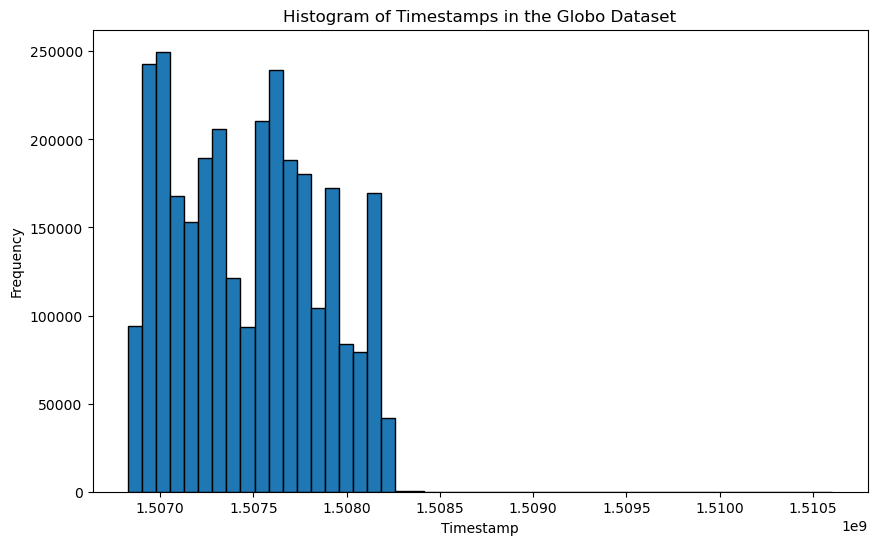

In [12]:
import matplotlib.pyplot as plt
# Plot histogram of the timestamp column
plt.figure(figsize=(10, 6))
plt.hist(df['click_timestamp'], bins=50, edgecolor='k')
plt.title('Histogram of Timestamps in the Globo Dataset')
plt.xlabel('Timestamp')
plt.ylabel('Frequency')
plt.show()

In [33]:
timestamp_counts = df['click_timestamp'].value_counts().sort_index(ascending=False)
cumulative_counts = timestamp_counts.cumsum()
total_counts = cumulative_counts.max()
threshold_count = total_counts * 0.1
threshold_timestamp = cumulative_counts[cumulative_counts >= threshold_count].index[0]

In [34]:
filtered_df = df[df['click_timestamp'] >= threshold_timestamp]

In [15]:
df

,user_id,click_article_id,click_timestamp
0,0,157541,1.506827e+09
1,0,68866,1.506827e+09
2,1,235840,1.506827e+09
3,1,96663,1.506827e+09
4,2,119592,1.506827e+09
...,...,...,...
2564,10051,84911,1.508212e+09
2565,322896,30760,1.508212e+09
2566,322896,157507,1.508212e+09
2567,123718,234481,1.508212e+09


In [16]:
filtered_df

,user_id,click_article_id,click_timestamp
4289,22712,158772,1.508196e+09
4290,22712,284638,1.508633e+09
4291,22712,95633,1.508678e+09
4292,22712,95524,1.508679e+09
4293,22712,184427,1.508679e+09
...,...,...,...
2564,10051,84911,1.508212e+09
2565,322896,30760,1.508212e+09
2566,322896,157507,1.508212e+09
2567,123718,234481,1.508212e+09


## Dataset Preprocessing to Interaction Matrix

In [35]:
from recpack.matrix import InteractionMatrix
from recpack.preprocessing.preprocessors import DataFramePreprocessor

item_ix = 'click_article_id'
user_ix = 'user_id'
timestamp_ix = 'click_timestamp'

preprocessor = DataFramePreprocessor(item_ix=item_ix, user_ix=user_ix, timestamp_ix=timestamp_ix)

interaction_matrix = preprocessor.process(filtered_df)

  0%|          | 0/298819 [00:00<?, ?it/s]

  0%|          | 0/298819 [00:00<?, ?it/s]

In [42]:
interaction_matrix.values

<Compressed Sparse Row sparse matrix of dtype 'int32'
	with 296356 stored elements and shape (81233, 10303)>

In [38]:
interaction_matrix.num_interactions

298819

In [37]:
interaction_matrix.properties

InteractionMatrix.InteractionMatrixProperties(num_users=81233, num_items=10303, has_timestamps=True)

## TimedLastItemPrediction Scenario Splitting of Data

(array([11940.,  7309., 16786., 29139., 36120.,  8249., 45830., 66290.,
        47406., 27855.]),
 array([1.50802851e+09, 1.50804683e+09, 1.50806515e+09, 1.50808347e+09,
        1.50810179e+09, 1.50812011e+09, 1.50813843e+09, 1.50815675e+09,
        1.50817507e+09, 1.50819339e+09, 1.50821171e+09]),
 <BarContainer object of 10 artists>)

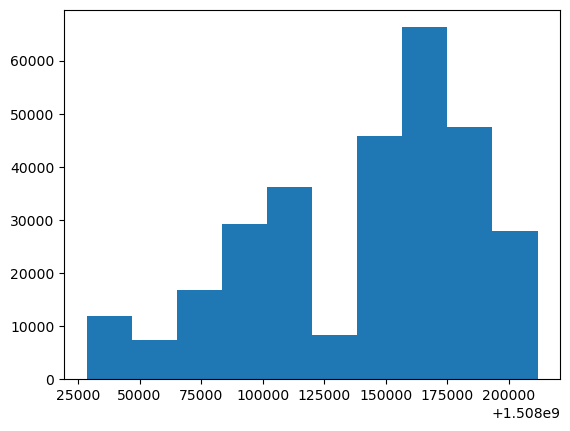

In [24]:
import matplotlib.pyplot as plt
# Histogram of interactions over time
tt = interaction_matrix.timestamps.values[int(0.999 * len(interaction_matrix.timestamps.values))]
plt.hist(interaction_matrix.timestamps_lte(tt).timestamps.values)

In [25]:
interaction_matrix.timestamps.values
t_80 = interaction_matrix.timestamps.values[int(0.8 * len(interaction_matrix.timestamps.values))]
t_validate_80 = interaction_matrix.timestamps.values[int(0.8 * 0.8 * len(interaction_matrix.timestamps.values))]
print(t_80, t_validate_80)

1508184661.438 1508164951.091


In [ ]:
scenario = TimedLastItemPrediction(t = t_80, t_validation = t_validate_80, validation=True)
scenario.split(interaction_matrix)

## Experimental RecPack Pipeline

In [43]:
pipeline_builder = PipelineBuilder()
ok = (scenario._validation_data_in, scenario._validation_data_out)
pipeline_builder.set_data_from_scenario(scenario)


# Add the baseline algorithms
#pipeline_builder.add_algorithm('ItemKNN', grid={'K': [100, 200, 400, 800]})
#pipeline_builder.add_algorithm('EASE', grid={'l2': [10, 100, 1000], 'alpha': [0, 0.1, 0.5]})

# Add our LightGCN algorithm
pipeline_builder.add_algorithm(
    'LightGCNAlgorithm1',
    grid={
        'learning_rate': [0.1, 0.01, 0.001],
        'embedding_dim': [100, 200, 400]
    },
    params={
        'max_epochs': 5,
        'batch_size': 1024,
        'n_layers': 3
    }
)

# Add NDCG, Recall, and HR metrics to be evaluated at 10, 20, and 50
pipeline_builder.add_metric('NDCGK', [10, 20, 50])
pipeline_builder.add_metric('RecallK', [10, 20, 50])
pipeline_builder.add_metric('HitK', [10, 20, 50])

# Set the optimisation metric
pipeline_builder.set_optimisation_metric('RecallK', 20)

# Construct pipeline
pipeline = pipeline_builder.build()

# Debugging: Output the shape of the training data
#print(f"Training data shape: {im.shape}")

# Run pipeline, will first do optimisation, and then evaluation
pipeline.run()

/opt/conda/lib/python3.11/site-packages/recpack/pipelines/pipeline_builder.py:145: UserWarning: Grid parameter for add_algorithm function will be deprecated in favour of optimisation_info.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_58233/4206860820.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  user_indices = torch.tensor(user_indices).to(self.device)
/tmp/ipykernel_58233/4206860820.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_item_indices = torch.tensor(pos_item_indices).to(self.device)
/tmp/ipykernel_58233/4206860820.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neg_item_indices = torch.tensor(neg_item_indices).to(self.device).squeeze()


2024-08-05 14:36:41,034 - base - recpack - INFO - Processed epoch 0 in 3.24 s.Batch Training Loss = 0.1401
2024-08-05 14:41:13,938 - stopping_criterion - recpack - INFO - StoppingCriterion has value 1.7272945263249904, which is better than previous iterations.
2024-08-05 14:41:13,941 - base - recpack - INFO - Model improved. Storing better model.
2024-08-05 14:41:14,027 - base - recpack - INFO - Evaluation at end of 0 took 272.99 s.
2024-08-05 14:41:17,125 - base - recpack - INFO - Processed epoch 1 in 3.10 s.Batch Training Loss = 0.1267
2024-08-05 14:45:49,886 - stopping_criterion - recpack - INFO - StoppingCriterion has value 2.4967495701607896, which is worse than previous iterations.
2024-08-05 14:45:50,112 - base - recpack - INFO - Evaluation at end of 1 took 272.99 s.
2024-08-05 14:45:53,084 - base - recpack - INFO - Processed epoch 2 in 2.97 s.Batch Training Loss = 0.1017
2024-08-05 14:50:21,275 - stopping_criterion - recpack - INFO - StoppingCriterion has value 2.51143132512017

/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:509: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model_ = torch.load(self.best_model)
/tmp/ipykerne

2024-08-05 15:04:50,239 - base - recpack - INFO - Processed epoch 0 in 3.08 s.Batch Training Loss = 0.1683
2024-08-05 15:09:18,176 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.6616383723221656, which is better than previous iterations.
2024-08-05 15:09:18,179 - base - recpack - INFO - Model improved. Storing better model.
2024-08-05 15:09:18,265 - base - recpack - INFO - Evaluation at end of 0 took 268.03 s.
2024-08-05 15:09:21,355 - base - recpack - INFO - Processed epoch 1 in 3.09 s.Batch Training Loss = 0.0759
2024-08-05 15:13:46,717 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.6667560179803089, which is worse than previous iterations.
2024-08-05 15:13:46,745 - base - recpack - INFO - Evaluation at end of 1 took 265.39 s.
2024-08-05 15:13:50,353 - base - recpack - INFO - Processed epoch 2 in 3.61 s.Batch Training Loss = 0.0711
2024-08-05 15:18:24,363 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.67461322163576

/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:509: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model_ = torch.load(self.best_model)
/tmp/ipykerne

2024-08-05 15:32:45,385 - base - recpack - INFO - Processed epoch 0 in 3.15 s.Batch Training Loss = 0.5526
2024-08-05 15:37:09,868 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.688106838060674, which is better than previous iterations.
2024-08-05 15:37:09,869 - base - recpack - INFO - Model improved. Storing better model.
2024-08-05 15:37:09,956 - base - recpack - INFO - Evaluation at end of 0 took 264.57 s.
2024-08-05 15:37:13,092 - base - recpack - INFO - Processed epoch 1 in 3.13 s.Batch Training Loss = 0.2122
2024-08-05 15:41:42,296 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.6800185465543308, which is worse than previous iterations.
2024-08-05 15:41:42,324 - base - recpack - INFO - Evaluation at end of 1 took 269.23 s.
2024-08-05 15:41:45,661 - base - recpack - INFO - Processed epoch 2 in 3.34 s.Batch Training Loss = 0.1224
2024-08-05 15:46:16,640 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.674338054320667

/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:509: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model_ = torch.load(self.best_model)
/tmp/ipykerne

2024-08-05 16:00:46,505 - base - recpack - INFO - Processed epoch 0 in 4.10 s.Batch Training Loss = 0.1672
2024-08-05 16:05:20,801 - stopping_criterion - recpack - INFO - StoppingCriterion has value 2.233627735014319, which is better than previous iterations.
2024-08-05 16:05:20,802 - base - recpack - INFO - Model improved. Storing better model.
2024-08-05 16:05:20,957 - base - recpack - INFO - Evaluation at end of 0 took 274.45 s.
2024-08-05 16:05:24,766 - base - recpack - INFO - Processed epoch 1 in 3.81 s.Batch Training Loss = 0.1628
2024-08-05 16:09:57,372 - stopping_criterion - recpack - INFO - StoppingCriterion has value 2.956243833264948, which is worse than previous iterations.
2024-08-05 16:09:57,384 - base - recpack - INFO - Evaluation at end of 1 took 272.62 s.
2024-08-05 16:10:01,369 - base - recpack - INFO - Processed epoch 2 in 3.98 s.Batch Training Loss = 0.1279
2024-08-05 16:14:28,972 - stopping_criterion - recpack - INFO - StoppingCriterion has value 2.550109534507217,

/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:509: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model_ = torch.load(self.best_model)
/tmp/ipykerne

2024-08-05 16:28:54,810 - base - recpack - INFO - Processed epoch 0 in 4.22 s.Batch Training Loss = 0.1496
2024-08-05 16:33:30,642 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.6693586883867589, which is better than previous iterations.
2024-08-05 16:33:30,645 - base - recpack - INFO - Model improved. Storing better model.
2024-08-05 16:33:30,761 - base - recpack - INFO - Evaluation at end of 0 took 275.95 s.
2024-08-05 16:33:35,163 - base - recpack - INFO - Processed epoch 1 in 4.40 s.Batch Training Loss = 0.0778
2024-08-05 16:38:01,922 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.6821232059525119, which is worse than previous iterations.
2024-08-05 16:38:02,169 - base - recpack - INFO - Evaluation at end of 1 took 267.00 s.
2024-08-05 16:38:06,242 - base - recpack - INFO - Processed epoch 2 in 4.07 s.Batch Training Loss = 0.0703
2024-08-05 16:42:37,501 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.70259667636086

/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:509: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model_ = torch.load(self.best_model)
/tmp/ipykerne

2024-08-05 16:56:58,083 - base - recpack - INFO - Processed epoch 0 in 4.22 s.Batch Training Loss = 0.4774
2024-08-05 17:01:25,427 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.6851879459209809, which is better than previous iterations.
2024-08-05 17:01:25,429 - base - recpack - INFO - Model improved. Storing better model.
2024-08-05 17:01:25,547 - base - recpack - INFO - Evaluation at end of 0 took 267.46 s.
2024-08-05 17:01:29,756 - base - recpack - INFO - Processed epoch 1 in 4.21 s.Batch Training Loss = 0.1482
2024-08-05 17:06:01,877 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.6758072182468998, which is worse than previous iterations.
2024-08-05 17:06:01,888 - base - recpack - INFO - Evaluation at end of 1 took 272.13 s.
2024-08-05 17:06:05,923 - base - recpack - INFO - Processed epoch 2 in 4.03 s.Batch Training Loss = 0.0979
2024-08-05 17:10:32,560 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.67026602899707

/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:509: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model_ = torch.load(self.best_model)
/tmp/ipykerne

2024-08-05 17:24:55,600 - base - recpack - INFO - Processed epoch 0 in 5.37 s.Batch Training Loss = 0.2422
2024-08-05 17:29:21,019 - stopping_criterion - recpack - INFO - StoppingCriterion has value 2.6094804650237604, which is better than previous iterations.
2024-08-05 17:29:21,020 - base - recpack - INFO - Model improved. Storing better model.
2024-08-05 17:29:21,244 - base - recpack - INFO - Evaluation at end of 0 took 265.64 s.
2024-08-05 17:29:25,746 - base - recpack - INFO - Processed epoch 1 in 4.50 s.Batch Training Loss = 0.2328
2024-08-05 17:33:54,954 - stopping_criterion - recpack - INFO - StoppingCriterion has value 3.3035740336363344, which is worse than previous iterations.
2024-08-05 17:33:54,966 - base - recpack - INFO - Evaluation at end of 1 took 269.22 s.
2024-08-05 17:33:59,523 - base - recpack - INFO - Processed epoch 2 in 4.56 s.Batch Training Loss = 0.1898
2024-08-05 17:38:27,254 - stopping_criterion - recpack - INFO - StoppingCriterion has value 3.40622727845172

/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:509: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model_ = torch.load(self.best_model)
/tmp/ipykerne

2024-08-05 17:52:59,882 - base - recpack - INFO - Processed epoch 0 in 6.22 s.Batch Training Loss = 0.1343
2024-08-05 17:57:25,116 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.6798937271689557, which is better than previous iterations.
2024-08-05 17:57:25,118 - base - recpack - INFO - Model improved. Storing better model.
2024-08-05 17:57:25,344 - base - recpack - INFO - Evaluation at end of 0 took 265.46 s.
2024-08-05 17:57:31,633 - base - recpack - INFO - Processed epoch 1 in 6.29 s.Batch Training Loss = 0.0759
2024-08-05 18:02:02,408 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.7044561421880566, which is worse than previous iterations.
2024-08-05 18:02:02,421 - base - recpack - INFO - Evaluation at end of 1 took 270.78 s.
2024-08-05 18:02:08,755 - base - recpack - INFO - Processed epoch 2 in 6.33 s.Batch Training Loss = 0.0687
2024-08-05 18:06:37,378 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.72087669202042

/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:509: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model_ = torch.load(self.best_model)
/tmp/ipykerne

2024-08-05 18:21:12,393 - base - recpack - INFO - Processed epoch 0 in 6.35 s.Batch Training Loss = 0.4009
2024-08-05 18:25:39,011 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.6816916252716861, which is better than previous iterations.
2024-08-05 18:25:39,014 - base - recpack - INFO - Model improved. Storing better model.
2024-08-05 18:25:39,287 - base - recpack - INFO - Evaluation at end of 0 took 266.89 s.
2024-08-05 18:25:45,615 - base - recpack - INFO - Processed epoch 1 in 6.33 s.Batch Training Loss = 0.1118
2024-08-05 18:30:12,792 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.6718066178344262, which is worse than previous iterations.
2024-08-05 18:30:12,843 - base - recpack - INFO - Evaluation at end of 1 took 267.23 s.
2024-08-05 18:30:19,179 - base - recpack - INFO - Processed epoch 2 in 6.33 s.Batch Training Loss = 0.0842
2024-08-05 18:34:51,835 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.66743258681241

/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:509: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model_ = torch.load(self.best_model)
/tmp/ipykerne

2024-08-05 18:49:19,392 - base - recpack - INFO - Processed epoch 0 in 3.16 s.Batch Training Loss = 0.1670
2024-08-05 18:53:46,718 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.661989290180028, which is better than previous iterations.
2024-08-05 18:53:46,722 - base - recpack - INFO - Model improved. Storing better model.
2024-08-05 18:53:46,791 - base - recpack - INFO - Evaluation at end of 0 took 267.40 s.
2024-08-05 18:53:49,783 - base - recpack - INFO - Processed epoch 1 in 2.99 s.Batch Training Loss = 0.0773
2024-08-05 18:58:21,464 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.6634138281580129, which is worse than previous iterations.
2024-08-05 18:58:21,478 - base - recpack - INFO - Evaluation at end of 1 took 271.69 s.
2024-08-05 18:58:24,857 - base - recpack - INFO - Processed epoch 2 in 3.38 s.Batch Training Loss = 0.0735
2024-08-05 19:02:54,561 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.673988098007243

/opt/conda/lib/python3.11/site-packages/recpack/algorithms/base.py:509: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model_ = torch.load(self.best_model)


## Results

In [44]:
pipeline.get_metrics()

,NDCGK_10,NDCGK_20,NDCGK_50,RecallK_10,RecallK_20,RecallK_50,HitK_10,HitK_20,HitK_50
"LightGCNAlgorithm(batch_size=1024,embedding_dim=100,keep_last=False,learning_rate=0.01,max_epochs=5,max_iter_no_change=5,min_improvement=0.01,n_layers=3,predict_topK=None,reg_weight=1e-05,save_best_to_file=False,seed=2672830196,stop_early=True,stopping_criterion=<recpack.algorithms.stopping_criterion.StoppingCriterion object at 0x7fadcc7baa10>,validation_sample_size=None)",0.012028,0.013361,0.015955,0.020156,0.025428,0.038824,0.020156,0.025428,0.038824
